In [134]:
# Team Members:
#   Kavya Dhiman B22110

#   For regression I first cleaned data by removing nan values and also rows where BP is negative
#   Then i found correlation of attributes with target and dropped those with lesser correlation
#   Then i used PCA to make the data one dimensional and selected degree 5 for simple regression
#   For classification i used Bayesian Classifiers where again i used that 1 dimensional data 
#   to find mean and standard deviation for each label then classified accordingly

In [135]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics as mat

# Reading data and dropping NAN values and rows where BP is negative

train_data = pd.read_csv("ML101_train_dataset.csv").dropna()
train_data = train_data[train_data["Systolic BP"] > 0]
train_data = train_data[train_data["Diastolic BP"] > 0]
test_data = pd.read_csv("ML101_dataset_test_feature.csv").dropna()

reg_train_data = train_data.drop("Gender", axis=1)

# Dropping columns with less correlation with the target

def find_correlation(ip_arr1, ip_arr2):
    a1 = ip_arr1 - ip_arr1.mean()
    a2 = ip_arr2 - ip_arr2.mean()
    fa = a1 * a2
    return np.sum(fa) / np.sum(a1 ** 2) ** (1/2) / np.sum(a2 ** 2) ** (1/2) 

def drop_attributes(ip_data, target):
    cor_dict = {}
    for col_name in ip_data.columns[:-3]:
        cor_dict[col_name] = find_correlation(np.array(ip_data[col_name]), np.array(ip_data[target]))

    related_attributes = []
    for attribute in cor_dict:
        if cor_dict[attribute] > 0.1:
            related_attributes.append(attribute)
        
    for col_name in ip_data.columns[:-3]:
        if col_name not in related_attributes:
            ip_data.drop(col_name, axis=1, inplace=True)


drop_attributes(reg_train_data, "Systolic BP")
drop_attributes(reg_train_data, "Diastolic BP")
reg_train_data.drop("LifeStyle", axis=1, inplace=True)
print(reg_train_data)


       Caloric Intake  Cholesterol level  Systolic BP  Diastolic BP
0              1714.0         185.408550   172.813045     75.552416
2              1366.0         212.625051   172.905053     87.816911
6              1547.0         164.797289   166.152809     72.226524
14             3351.0         196.103996   228.689531    108.012586
15             2335.0         165.880893   180.897785     73.779239
...               ...                ...          ...           ...
99988          1856.0         202.036036   197.034190     89.469280
99993          3219.0         224.564016   238.720193    247.405796
99996          2233.0         227.699267   205.758576     97.740461
99998          1434.0         140.865132   149.675364    200.964967
99999          3458.0         177.339752   216.590126     96.114712

[25208 rows x 4 columns]


In [136]:
# Doing PCA to reduce data from 2 to 1 dimensions

def get_data_mat(ip_data):
    X = []
    for col_name in ip_data.columns[:-2]:
        X.append(np.array(ip_data[col_name]))
    return np.matrix(X)


def PCA(ip_data):

    # eigen analysis

    X = get_data_mat(reg_train_data)
    cov_mat = np.matmul(X, X.T)
    e_values, e_vectors = np.linalg.eig(cov_mat)
    e_vector = e_vectors.T[0]

    # Reducing

    principal_component = []
    for i in range(len(ip_data)):
        X = np.matrix(ip_data.iloc[i])
        principal_component.append(np.array(np.matmul(X, e_vector.T))[0][0])
    
    return np.array(principal_component)

data_for_pca = reg_train_data.drop("Systolic BP", axis=1)
data_for_pca = data_for_pca.drop("Diastolic BP", axis=1)
principal_component_train = PCA(data_for_pca)

pc_sys_bp = {"PC1" : principal_component_train, "Systolic BP" : reg_train_data["Systolic BP"]}
pc_dia_bp = {"PC1" : principal_component_train, "Diastolic BP" : reg_train_data["Diastolic BP"]}
pc_sys_bp = pd.DataFrame(pc_sys_bp)
pc_dia_bp = pd.DataFrame(pc_dia_bp)

print(pc_sys_bp)
print(pc_dia_bp)


               PC1  Systolic BP
0      1722.714699   172.813045
2      1377.427076   172.905053
6      1554.689652   166.152809
14     3356.541086   228.689531
15     2340.881101   180.897785
...            ...          ...
99988  1865.524229   197.034190
99993  3226.823118   238.720193
99996  2243.396431   205.758576
99998  1440.306069   149.675364
99999  3461.988767   216.590126

[25208 rows x 2 columns]
               PC1  Diastolic BP
0      1722.714699     75.552416
2      1377.427076     87.816911
6      1554.689652     72.226524
14     3356.541086    108.012586
15     2340.881101     73.779239
...            ...           ...
99988  1865.524229     89.469280
99993  3226.823118    247.405796
99996  2243.396431     97.740461
99998  1440.306069    200.964967
99999  3461.988767     96.114712

[25208 rows x 2 columns]


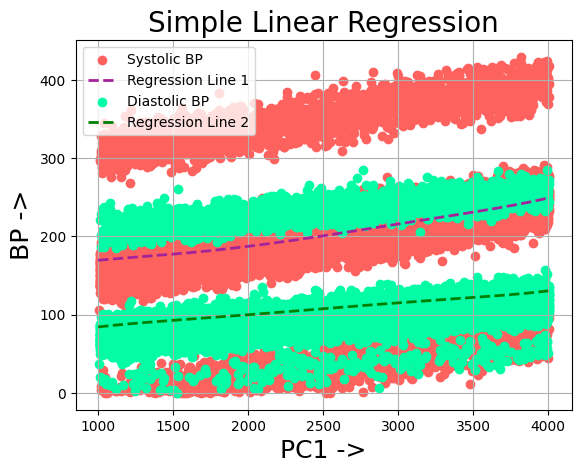

Systolic BP RMSE: 66.17 
Diastolic BP RMSE: 43.46


In [137]:
# Finding parameters for regression

def get_parameters(ip_data, attribute, target, degree):
    data = ip_data[attribute]
    Y = np.mat(ip_data[target]).T
    X = []
    for i in data:
        row = []
        for power in range(degree+1):
            row.append(i ** power)
        X.append(row) 
    X = np.mat(X)
    W = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T), Y)
    
    return W

def predict(ip_data, attribute, target, parameters, degree):
    predictions = []
    true_val = list(ip_data[target])
    for i in ip_data[attribute]:
        X = []
        for power in range(degree + 1):
            X.append(i ** power)
        X = np.mat(X)
        predictions.append(np.array(np.matmul(parameters.T, X.T))[0][0])
    return predictions, true_val

def curve(x, degree, parameters):
    y = 0
    for i in range(degree+1):
        y += x ** i * np.array(parameters)[i][0]
    return y

def cal_RMSE(pred_val, true_val):
    sum = 0
    for i in range(len(pred_val)):
        sum += (pred_val[i] - true_val[i]) ** 2
    sum /= len(pred_val)
    return float(f"{sum ** (1/2):.2f}")

# Using deg 5 in simple linear regression because minimum rmse on training data

deg = 5
parameters_sys = get_parameters(pc_sys_bp, "PC1", "Systolic BP", deg)
pred_val, true_val = predict(pc_sys_bp, "PC1", "Systolic BP", parameters_sys, deg)

x = np.arange(1000, 4000, 0.1)
plt.scatter(pc_sys_bp["PC1"], pc_sys_bp["Systolic BP"], color="#fd625e")
plt.xlabel("PC1 ->", fontsize=18)
plt.ylabel("BP ->", fontsize=18)
plt.title("Simple Linear Regression", fontsize=20)
plt.grid(True)
plt.plot(x, curve(x, deg, parameters_sys), color="#a4239a", linestyle="dashed", linewidth=2)

rmse1 = cal_RMSE(pred_val, true_val)

parameters_dia = get_parameters(pc_dia_bp, "PC1", "Diastolic BP", deg)
pred_val, true_val = predict(pc_dia_bp, "PC1", "Diastolic BP", parameters_dia, deg)

plt.scatter(pc_dia_bp["PC1"], pc_dia_bp["Diastolic BP"], color="#03fca5")
plt.title("Simple Linear Regression", fontsize=20)
plt.grid(True)
plt.plot(x, curve(x, deg, parameters_dia), color="green", linestyle="dashed", linewidth=2)
plt.legend(["Systolic BP", "Regression Line 1", "Diastolic BP", "Regression Line 2"])
plt.show()

rmse2 = cal_RMSE(pred_val, true_val)
print("Systolic BP RMSE:", rmse1, "\nDiastolic BP RMSE:", rmse2)

In [138]:
# Predicting Test Data

cols = ["Caloric Intake", "Cholesterol level"]
predicting_data = test_data
for col_name in test_data.columns:
    if col_name not in cols: predicting_data.drop(col_name, axis=1, inplace=True)

# Reducing dimensionality

principal_component = PCA(predicting_data)

def do_predictions(ip_data, parameters, deg):
    predictions = []
    for i in ip_data:
        X = []
        for power in range(deg + 1):
            X.append(i ** power)
        X = np.mat(X)
        predictions.append(np.array(np.matmul(parameters.T, X.T))[0][0])
    return predictions

systolic_bp_pred = do_predictions(principal_component, parameters_sys, 5)
diastolic_bp_pred = do_predictions(principal_component, parameters_dia, 5)

print(systolic_bp_pred)
print(diastolic_bp_pred)
pred_csv = {"Systolic BP" : systolic_bp_pred, "Diastolic BP" : diastolic_bp_pred, "ID" : np.arange(0, 5000, 1)}
pred_csv = pd.DataFrame(pred_csv)
pred_csv.drop(pred_csv.columns[pred_csv.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
pred_csv.to_csv("predictions_BP.csv")

[176.25844875373335, 227.50856902849404, 211.81022264275472, 214.51516285438817, 180.7787806411267, 225.2994867017792, 172.03014608093486, 217.78082727444462, 211.86295458830546, 213.74839844344268, 219.02371546099067, 224.37737079621576, 191.06529616593815, 245.36465487594467, 222.27166799405643, 204.46873715767612, 215.47045241951494, 203.44251494341873, 212.93612000081055, 243.13360870658482, 217.01018943749446, 206.79961750951844, 222.91104321770212, 247.33453873962105, 178.34206865542606, 181.48048081285216, 192.0043600005222, 226.22978524654144, 230.69368146507912, 229.39486634960582, 172.36164163130562, 182.7319626795234, 202.77880147472573, 175.840281948036, 171.55513773691484, 175.10737237208477, 243.66938334818087, 184.66411612187935, 193.91793197015537, 179.4756310283308, 171.84834465019028, 225.4257568495965, 202.37920456411615, 214.62292279151274, 244.3319291286956, 172.6053083901149, 175.09306761824155, 231.86862080476703, 172.26368263774452, 171.5621718311309, 218.053874

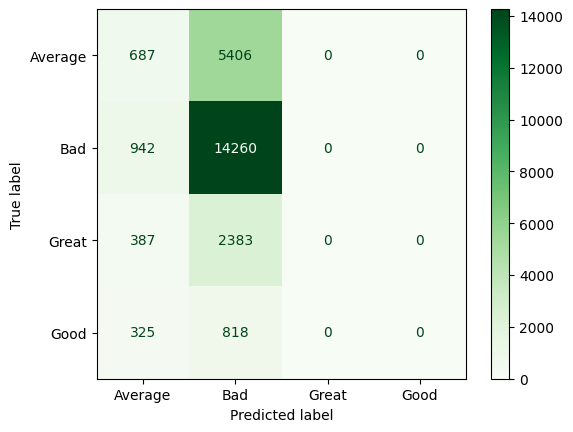

Model Accuracy: 59.295%


In [139]:
# Doing classification

classification_dict = {"PC1" : principal_component_train, "LifeStyle" : train_data["LifeStyle"]}
classification_dict = pd.DataFrame(classification_dict)

# Getting parameters for each label 

def get_parameters(ip_data):
    parameters = {}
    for label in ip_data["LifeStyle"]:
        if label not in parameters: parameters[label] = np.array(ip_data["PC1"][ip_data["LifeStyle"] == label])
        if len(parameters[label]) > 1000: parameters[label] = parameters[label]

    for label in parameters.keys():
        mu, sig, count = parameters[label].mean(), parameters[label].std(), len(parameters[label])
        parameters[label] = [mu, sig, count]
    return parameters

# P(x | Ci)

def get_prob(x, parameters):
    return 1/((2*np.pi)**(1/2)*parameters[1]) * (np.e ** (-1/(2*parameters[1]**2) * (x - parameters[0])**2))

# P(Ci)

def get_class_prob(label, pred_count):
    sum = 0
    for name in pred_count:
        sum += pred_count[name][2]
    return pred_count[label][2] / sum

# P(x)

def get_total_prob(x, parameters):
    prob = 0.0
    for label in parameters.keys():
        prob += get_prob(x, parameters[label][:-1]) * get_class_prob(label, parameters)
    return prob

# P(Ci | x)

def classify(ip_data, parameters):
    predictions = []
    max_dict = {}
    for key in parameters.keys():
        max_dict[key] = 0.0
    
    for data in ip_data["PC1"]:
        for label in max_dict.keys():
            max_dict[label] = get_class_prob(label, parameters) * get_prob(data, parameters[label]) / get_total_prob(data, parameters)
        predicted_class  = max(max_dict, key=lambda x : max_dict[x])
        predictions.append(predicted_class)
    return predictions

parameters = get_parameters(classification_dict)

predictions = classify(classification_dict, parameters)
true_label = list(classification_dict["LifeStyle"])

confusion_mat = mat.confusion_matrix(true_label, predictions)

cm_display = mat.ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels=parameters.keys())
cm_display.plot(cmap="Greens")
plt.show()

TP = confusion_mat[0][0]
TN = confusion_mat[1][1] + confusion_mat[2][2] + confusion_mat[3][3]
Total = 25208

accuracy = (TP + TN) / Total * 100
out_str = f"Model Accuracy: {accuracy:.3f}%"
print(out_str)

In [140]:
# Classifying test samples
# I already have test data as principal component
principal_component = {"PC1" : principal_component}
predicted_labels = classify(principal_component, parameters)
print(predicted_labels)

new_csv = {"LifeStyle" : predicted_labels, "ID" : np.arange(0, 5000, 1)}
new_csv = pd.DataFrame(new_csv)
new_csv.drop(new_csv.columns[new_csv.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
new_csv.to_csv("predictions_LifeStyle.csv")

['Average', 'Bad', 'Bad', 'Bad', 'Average', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Average', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Average', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Average', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Average', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Average', 'Bad', 'Bad', 'Bad', 'Average', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Average', 'Average', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 